# Imports and reading data

In [1]:
import duckdb
import pandas as pd

In [2]:
pd.options.display.max_colwidth = 500

In [3]:
# converted sqlite tables to duckdb's columnar storage
# see sqlite_to_duckdb.py
duckdb_path = 'bitcoin_principles-duckdb.db'

In [4]:
duckdb.sql(f"ATTACH '{duckdb_path}'; USE '{duckdb_path[:-3]}';")

In [5]:
duckdb.sql('show tables')

┌─────────────────────┐
│        name         │
│       varchar       │
├─────────────────────┤
│ block_height_votes  │
│ block_times         │
│ federations         │
│ ln_contracts        │
│ sessions            │
│ transaction_inputs  │
│ transaction_outputs │
│ transactions        │
└─────────────────────┘

## Missing one table
`session_times` is missing because it's a view, but we'll materialize it for better analysis performance since the database is now static

In [7]:
# from schema/v0.sql (alternatively DDL can be retrieved from sqlite_master meta table)
# BTW, this seems very convoluted, I'm sure the same thing can be achieved with fewer CTEs
duckdb.sql("""
CREATE TABLE IF NOT EXISTS session_times AS
WITH session_votes AS (
    SELECT
        s.session_index,
        s.federation_id
    FROM
        sessions s
), sorted_votes AS (
    SELECT
        sv.session_index,
        sv.federation_id,
        height_vote,
        ROW_NUMBER() OVER (PARTITION BY sv.federation_id, sv.session_index ORDER BY height_vote) AS rn,
        COUNT(bhv.height_vote) OVER (PARTITION BY sv.federation_id, sv.session_index) AS total_votes
    FROM
        session_votes sv
            LEFT JOIN
        block_height_votes bhv ON sv.session_index = bhv.session_index
            AND sv.federation_id = bhv.federation_id
), session_max_height AS (
    SELECT
        session_index,
        federation_id,
        MAX(height_vote) AS max_height_vote -- Include max to handle NULLs in averaging
    FROM
        sorted_votes
    WHERE
        total_votes > 0
    GROUP BY
        federation_id, session_index
), session_time AS (
    SELECT
        sv.session_index,
        sv.federation_id,
        (
            SELECT
                bt.timestamp
            FROM
                block_times bt
            WHERE
                mh.max_height_vote IS NOT NULL
              AND bt.block_height = mh.max_height_vote
        ) AS timestamp
    FROM
        session_votes sv
            LEFT JOIN
        session_max_height mh ON sv.session_index = mh.session_index AND sv.federation_id = mh.federation_id
), grouped_sessions AS (
    SELECT
        *,
        SUM(CASE WHEN timestamp IS NOT NULL THEN 1 ELSE 0 END) OVER (PARTITION BY federation_id ORDER BY session_index) AS time_group
    FROM
        session_time
), propagated_times AS (
    SELECT
        session_index,
        federation_id,
        FIRST_VALUE(timestamp) OVER (PARTITION BY federation_id, time_group ORDER BY session_index) AS estimated_session_timestamp
    FROM
        grouped_sessions
)
SELECT
    federation_id,
    session_index,
    estimated_session_timestamp
FROM
    propagated_times
ORDER BY
    federation_id, session_index;
""")

In [9]:
duckdb.sql('select hex(federation_id), session_index, estimated_session_timestamp from session_times LIMIT 3')

┌──────────────────────────────────────────────────────────────────┬───────────────┬─────────────────────────────┐
│                        hex(federation_id)                        │ session_index │ estimated_session_timestamp │
│                             varchar                              │     int64     │            int64            │
├──────────────────────────────────────────────────────────────────┼───────────────┼─────────────────────────────┤
│ B21068C84F5B12CA4FDF93F3E443D3BD7C27E8642D0D52EA2E4DCE6FDBBEE9DF │             0 │                  1712332271 │
│ B21068C84F5B12CA4FDF93F3E443D3BD7C27E8642D0D52EA2E4DCE6FDBBEE9DF │             1 │                  1712332271 │
│ B21068C84F5B12CA4FDF93F3E443D3BD7C27E8642D0D52EA2E4DCE6FDBBEE9DF │             2 │                  1712332271 │
└──────────────────────────────────────────────────────────────────┴───────────────┴─────────────────────────────┘

Looks good

# Data quality checks

and some exploratory data analysis

## Are session_index contiguous?

if no rows return, the answer is yes

In [10]:
duckdb.sql(
"""
SELECT s1.session_index AS s1_idx, s2.session_index AS s2_idx
FROM session_times s1
LEFT JOIN session_times s2 ON s1.session_index = s2.session_index+1
WHERE s1.session_index > 0 AND s2.session_index IS NULL
limit 10
""").df()

,s1_idx,s2_idx


## What modules exist in this federation?

In [11]:
duckdb.sql(
"""
SELECT 'in' AS in_out, kind, COUNT(*) AS tx_cnt
FROM transaction_inputs
GROUP BY kind

UNION ALL 
SELECT 'out' AS in_out, kind, COUNT(*) AS tx_cnt
FROM transaction_outputs
GROUP BY kind
""").df()

,in_out,kind,tx_cnt
0,in,stability_pool,5
1,in,ln,67156
2,in,wallet,63
3,in,mint,625018
4,out,stability_pool,7
5,out,ln,101878
6,out,wallet,47
7,out,mint,667548


## in `transaction_outputs` there is one more column, let's understand it

In [12]:
duckdb.sql(
"""
SELECT ln_contract_interaction_kind, COUNT(*) AS frq
FROM transaction_outputs
WHERE kind = 'ln'
GROUP BY ln_contract_interaction_kind
""").df()

,ln_contract_interaction_kind,frq
0,fund,66922
1,cancel,135
2,offer,34821


## Can there be multiple input kinds with the same txid?
There shouldn't be since the kind defined the fedimint module involved  
And since where checking this, could there be a txid associated with more than one session?

In [13]:
duckdb.sql(
"""
WITH t AS (
    SELECT t.txid,
        COUNT(DISTINCT tin.kind) AS in_kind_unq,
        COUNT(DISTINCT st.session_index) AS session_unq,
    FROM session_times st
    LEFT JOIN transactions t ON t.session_index = st.session_index AND t.federation_id = st.federation_id
    LEFT JOIN transaction_inputs tin ON t.txid = tin.txid AND t.federation_id = tin.federation_id
    WHERE t.txid IS NOT NULL
    GROUP BY t.txid
)
SELECT *
FROM t
WHERE in_kind_unq > 1 OR session_unq > 1
""").df()

,txid,in_kind_unq,session_unq


### And with outputs?

In [15]:
duckdb.sql(
"""
WITH t AS (
    SELECT hex(t.txid),
        COUNT(DISTINCT tout.kind) AS out_kind_unq,
        COUNT(DISTINCT st.session_index) AS session_unq,
    FROM session_times st
    LEFT JOIN transactions t ON t.session_index = st.session_index AND t.federation_id = st.federation_id
    LEFT JOIN transaction_outputs tout ON t.txid = tout.txid AND t.federation_id = tout.federation_id
    WHERE t.txid IS NOT NULL
    GROUP BY t.txid
)
SELECT *
FROM t
WHERE out_kind_unq > 1
""").df()

,hex(t.txid),out_kind_unq,session_unq
0,EA089C12ABDE8782BAAB322ECDDBC31C0293949AAE73F6BFD308B139E11F2F89,2,1
1,310C625DF19585A328AB205A8AA134AFD1562418F96FC29FB774E9B3D5F1B3B3,2,1
2,8442E3A4820552AD41B40D612BDC7B4AEE8434E3F8240F8AE5DDD7F504AC7770,2,1
3,6252D79EDC35672799D4C1A4EBE6E047ECB2A1B12CE9EA547DD697898DF9A087,2,1
4,1B5211EBE6D6B40652EDE3DA799F296B2830F2ABC776846415203043DA26942D,2,1
...,...,...,...
412,3A70720E018C9860C062E6AAA8D46FABD426978AFFB6A1BEB13F8CAE5C05DD72,2,1
413,BF4E3D0672CBC075BA7EA933A8E2C1A509DEBAFF439381D547FE0D2EFA80BB8F,2,1
414,CEC022EDD0F87098663E8771247023B1E946CEA8015BBB1A726356B390924A50,2,1
415,EC36ED65030469E1979481E3C7BF0BAFC5F87937963133B16A65D4DF39E569B5,2,1


### Curious...

Let's dive in

In [16]:
duckdb.sql(
"""
SELECT kinds, count(*) as frq
FROM (
    SELECT hex(txid) as txid_hex
    , list_sort(list_distinct(array_agg(kind))) AS kinds
    FROM transaction_outputs
    WHERE txid IN (
        SELECT txid
        FROM transaction_outputs
        GROUP BY txid
        HAVING COUNT(DISTINCT kind) > 1
    )
    GROUP BY txid
)
GROUP BY kinds
""").df()

,kinds,frq
0,"[mint, wallet]",2
1,"[ln, mint]",414
2,"[mint, stability_pool]",1


As long as "mint" is always one of the output kinds it's ok, it's the "cash back".

## Is (session_index, session_item) unique for each txid and vice-versa?

txid is a random hash, I'd rather use an ordinal column so that I have a sense of cronological order.  

In [17]:
duckdb.sql(
"""
SELECT count(*) as rows,
COUNT(DISTINCT txid) as txid_cnt,
COUNT(DISTINCT struct_pack(session_index, item_index)) AS session_item_cnt
FROM transactions
LIMIT 10
""")

┌────────┬──────────┬──────────────────┐
│  rows  │ txid_cnt │ session_item_cnt │
│ int64  │  int64   │      int64       │
├────────┼──────────┼──────────────────┤
│ 172091 │   172091 │           172091 │
└────────┴──────────┴──────────────────┘

# Preparing complete analysis table

We're ready, I think

In [18]:
session_transactions = duckdb.sql(
"""
SELECT st.session_index,
       epoch_ms(st.estimated_session_timestamp * 1000) AS session_time,
       t.item_index,
       hex(t.txid) as txid,
       tin.kind AS in_kind,
       tout.kind AS out_kind,
       tout.ln_contract_interaction_kind,
       tin.amount AS in_amount,
       tout.amount AS out_amount
FROM session_times st
LEFT JOIN transactions t ON t.session_index = st.session_index AND t.federation_id = st.federation_id
LEFT JOIN (
    SELECT federation_id, txid, kind
    , SUM(amount_msat) AS amount
    , COUNT(*) as item_cnt
    FROM transaction_inputs
    GROUP BY federation_id, txid, kind
) tin ON t.txid = tin.txid AND t.federation_id = tin.federation_id
LEFT JOIN (
    SELECT federation_id, txid, kind, ln_contract_interaction_kind, SUM(amount_msat) AS amount
    FROM transaction_outputs
    GROUP BY federation_id, txid, kind, ln_contract_interaction_kind
) tout ON t.txid = tout.txid AND t.federation_id = tout.federation_id
ORDER BY st.session_index, txid, item_index
""").df()

In [19]:
session_transactions[:3]

,session_index,session_time,item_index,txid,in_kind,out_kind,ln_contract_interaction_kind,in_amount,out_amount
0,0,2024-04-05 15:51:11,NaN,None,None,None,None,NaN,NaN
1,1,2024-04-05 15:51:11,NaN,None,None,None,None,NaN,NaN
2,2,2024-04-05 15:51:11,NaN,None,None,None,None,NaN,NaN


## Checking the range of time we're talking here

In [20]:
def mask(mask_expr:str, maskee:str = "true") -> str:
    return f"CASE WHEN {mask_expr} THEN {maskee} ELSE NULL END"

duckdb.sql(
f"""
SELECT 
MIN(session_index) AS first_session,
MAX(session_index) AS last_session,
MIN(session_time) AS first_timestamp,
MAX(session_time) AS last_timestamp,
MIN({mask("txid IS NOT NULL", "session_index")}) AS first_tx_session,
MAX({mask("txid IS NOT NULL", "session_index")}) AS last_tx_session,
MIN({mask("txid IS NOT NULL", "session_time")}) AS first_tx_timestamp,
MAX({mask("txid IS NOT NULL", "session_time")}) AS last_tx_timestamp,
FROM session_transactions
"""
).df()

,first_session,last_session,first_timestamp,last_timestamp,first_tx_session,last_tx_session,first_tx_timestamp,last_tx_timestamp
0,0,73627,2024-04-05 15:51:11,2024-07-30 20:39:52,219,73627,2024-04-06 00:34:18,2024-07-30 20:39:52


## Kind pairs

In [21]:
duckdb.sql(
f"""
select in_kind, out_kind, ln_contract_interaction_kind
, COUNT(*) as tx_cnt
, COUNT({mask("in_amount IS NOT NULL")}) AS in_amount_nonnull_cnt
, COUNT({mask("in_amount > 0")}) AS in_amount_positive_cnt
, COUNT({mask("out_amount IS NOT NULL")}) AS out_amount_nonnull_cnt
, COUNT({mask("out_amount > 0")}) AS out_amount_positive_cnt
from session_transactions 
WHERE in_kind IS NOT NULL OR out_kind IS NOT NULL
GROUP BY in_kind, out_kind, ln_contract_interaction_kind
ORDER BY in_kind, out_kind, ln_contract_interaction_kind
""").df()

,in_kind,out_kind,ln_contract_interaction_kind,tx_cnt,in_amount_nonnull_cnt,in_amount_positive_cnt,out_amount_nonnull_cnt,out_amount_positive_cnt
0,ln,mint,None,66913,66913,66913,66913,66913
1,ln,None,None,243,243,0,0,0
2,mint,ln,fund,66922,66922,66922,66922,66922
3,mint,mint,None,3352,3352,3352,3352,3352
4,mint,stability_pool,None,6,6,6,0,0
5,mint,wallet,None,47,47,47,47,47
6,stability_pool,mint,None,5,0,0,5,5
7,wallet,mint,None,63,63,63,63,63
8,None,ln,cancel,135,0,0,135,0
9,None,ln,offer,34821,0,0,34821,0


### Do the input and output amount match?

In [22]:
duckdb.sql(
"""
    SELECT in_kind, out_kind 
    , COUNT(*) as tx_cnt
    , COUNT(CASE WHEN in_amount = out_amount THEN true ELSE NULL END) AS amount_match_cnt
    , SUM(in_amount) AS in_total
    , SUM(out_amount) AS out_total
    FROM session_transactions 
    WHERE (in_kind IS NOT NULL OR out_kind IS NOT NULL)
    GROUP BY in_kind, out_kind
    ORDER BY in_kind, out_kind
""").df()

,in_kind,out_kind,tx_cnt,amount_match_cnt,in_total,out_total
0,ln,mint,66913,66913,1.183181e+11,1.183181e+11
1,ln,None,243,0,0.000000e+00,NaN
2,mint,ln,66922,66508,1.307557e+11,1.183327e+11
3,mint,mint,3352,2935,8.123362e+11,7.223970e+11
4,mint,stability_pool,6,0,1.000248e+10,NaN
5,mint,wallet,47,45,7.826968e+11,7.819290e+11
6,stability_pool,mint,5,0,NaN,9.999322e+09
7,wallet,mint,63,63,8.423759e+11,8.423759e+11
8,None,ln,34956,0,NaN,0.000000e+00
9,None,stability_pool,1,0,NaN,NaN


Not always... There are some special cases we have to look into  
Maybe, the outputs of a tx are split in more than one kind

In [23]:
duckdb.sql(
"""
WITH t1 AS (
    SELECT session_index, item_index, in_kind, out_kind 
    , SUM(COALESCE(in_amount, 0)) AS in_total
    , SUM(COALESCE(out_amount, 0)) AS out_total
    FROM session_transactions 
    GROUP BY session_index, item_index, in_kind, out_kind
),
t2 AS (
    PIVOT t1
    ON out_kind
    USING sum(out_total)
),
t3 AS (
    SELECT session_index, item_index, in_kind, in_total
    , ln, mint, stability_pool, wallet
    , COALESCE(ln,0) + COALESCE(mint,0) + COALESCE(stability_pool,0) + COALESCE(wallet,0) AS out_total 
    FROM t2
)
SELECT *
FROM t3
WHERE in_total != out_total
ORDER BY session_index, item_index
""").df()

,session_index,item_index,in_kind,in_total,ln,mint,stability_pool,wallet,out_total
0,2595,0.0,mint,1.458176e+06,NaN,2.176000e+03,0.0,NaN,2.176000e+03
1,2630,0.0,mint,5.000000e+09,NaN,NaN,0.0,NaN,0.000000e+00
2,2642,0.0,mint,7.260000e+05,NaN,NaN,0.0,NaN,0.000000e+00
3,2642,1.0,mint,1.460000e+05,NaN,NaN,0.0,NaN,0.000000e+00
4,2645,0.0,mint,5.000000e+09,NaN,NaN,0.0,NaN,0.000000e+00
5,2750,0.0,stability_pool,0.000000e+00,NaN,8.707540e+05,NaN,NaN,8.707540e+05
6,3143,0.0,mint,1.460000e+05,NaN,NaN,0.0,NaN,0.000000e+00
7,3833,0.0,stability_pool,0.000000e+00,NaN,1.000000e+06,NaN,NaN,1.000000e+06
8,3834,8.0,stability_pool,0.000000e+00,NaN,4.998455e+09,NaN,NaN,4.998455e+09
9,3834,12.0,stability_pool,0.000000e+00,NaN,4.998452e+09,NaN,NaN,4.998452e+09


The only cases where the inputs and total outputs do not match happens to be with stability_pool.  
And that makes sense, come to think of it, since it's a deal that is settled only in the future.

From what I gathered, this module was developped "in the wild" https://github.com/nope78787/stabilitypool and the settlement happens after an "epoch" upon which the amount of ecash that returns to the seeker and the amount that will stay with the provider will depend on the bitcoin price change based on some oracle.

Anyway, we can conclude that ecash is conserved.

# Tracking federation capitalization

* As soon as BTC is pegged to the federated wallet, it must be fully minted
* When using LN gateways, the provider handles the assets that leave the federation, so in practice it's only ecash in and out
* Same goes for stability_pools, for that matter
* And obviously, ecash transactions within the federation do not make money appear or disappear
* So the only way out is pegging out through the federated wallet (even if there is some cash back in the same tx)

In [24]:
pegs = duckdb.sql(
"""
WITH t1 AS (
    select session_time, session_index,	item_index
    , CASE WHEN in_kind = 'wallet' THEN 'peg-in' ELSE 'peg-out' END AS movement
    , CASE WHEN in_kind = 'wallet' THEN in_amount ELSE -out_amount END as amount
    from session_transactions 
    WHERE (in_kind = 'wallet' AND out_kind = 'mint') OR (in_kind = 'mint' AND out_kind = 'wallet')
)
SELECT session_time, session_index,	item_index, movement, amount,
SUM(amount) OVER(ORDER BY session_index, item_index ROWS UNBOUNDED PRECEDING) AS pegged_total
FROM t1
ORDER BY session_index, item_index
""").df()

## How much Bitcoin was pegged-in to this federation?

In [27]:
duckdb.sql(
"""
select sum(amount) / 1e11 AS btc_amount
, COUNT(*) AS transaction_count
, MIN(session_time) AS first_pegin_time
, MAX(session_time) AS last_pegin_time
from pegs 
where movement = 'peg-in'
""")

┌────────────┬───────────────────┬─────────────────────┬─────────────────────┐
│ btc_amount │ transaction_count │  first_pegin_time   │   last_pegin_time   │
│   double   │       int64       │      timestamp      │      timestamp      │
├────────────┼───────────────────┼─────────────────────┼─────────────────────┤
│ 8.42375871 │                63 │ 2024-04-06 00:34:18 │ 2024-07-28 16:55:48 │
└────────────┴───────────────────┴─────────────────────┴─────────────────────┘

## How much Bitcoin was pegged-out from this federation?

In [28]:
duckdb.sql(
"""
select sum(-amount) / 1e11 AS btc_amount
, COUNT(*) AS transaction_count
, MIN(session_time) AS first_pegin_time
, MAX(session_time) AS last_pegin_time
from pegs 
where movement = 'peg-out'
""")

┌────────────┬───────────────────┬─────────────────────┬─────────────────────┐
│ btc_amount │ transaction_count │  first_pegin_time   │   last_pegin_time   │
│   double   │       int64       │      timestamp      │      timestamp      │
├────────────┼───────────────────┼─────────────────────┼─────────────────────┤
│ 7.81928988 │                47 │ 2024-05-16 11:17:07 │ 2024-07-26 12:08:39 │
└────────────┴───────────────────┴─────────────────────┴─────────────────────┘

### What is the current on-chain balance of this federation?

In [27]:
duckdb.sql("select sum(amount) / 1e11 AS btc_amount from pegs")

┌────────────┐
│ btc_amount │
│   double   │
├────────────┤
│ 0.60446883 │
└────────────┘

# Visualizing

In [10]:
import plotly.express as px

In [69]:
def time_plot(df, title, xtitle, ytitle, **kwargs):
    extra_args = {
        'line_shape':'hv',
        **kwargs,
    }

    fig = px.line(df, *df.columns, title=title, **extra_args)

    fig.update_layout(
        xaxis_title=xtitle,
        yaxis_title=ytitle,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        ),
        yaxis=dict(
            fixedrange=False
        ),        
    )

    return fig

In [38]:
btc_value_over_time = pegs.assign(btc_value = lambda df: df.pegged_total / 1e11)[['session_time','btc_value']]

In [70]:
time_plot(btc_value_over_time, 'On-chain BTC over Time', 'Session estimated timestamp', 'Pegged BTC').show()

## More analysis

What else can we do?

* Share between modules
* Frequency and volume of tx witin the federation
* Frequency and volume of tx using the LN gateway
* Histogram of number of items per session
* Distribution amount per transaction (by kind)

### 1) Share between modules

In [56]:
modules_share = duckdb.sql(
"""
select CONCAT(in_kind, ' - ', out_kind) AS kind_pair
, COUNT(*) as tx_cnt
, GREATEST(SUM(in_amount), SUM(out_amount)) AS volume
from session_transactions 
WHERE in_kind IS NOT NULL AND out_kind IS NOT NULL
GROUP BY in_kind, out_kind
ORDER BY in_kind, out_kind
""").df()

In [60]:
modules_share

,kind_pair,tx_cnt,volume
0,ln - mint,66913,1.183181e+11
1,mint - ln,66922,1.307557e+11
2,mint - mint,3352,8.123362e+11
3,mint - stability_pool,6,1.000248e+10
4,mint - wallet,47,7.826968e+11
5,stability_pool - mint,5,9.999322e+09
6,wallet - mint,63,8.423759e+11


In [84]:
# just to have a coherent pairs sorting
kinds = session_transactions.in_kind.dropna().drop_duplicates()
pairs = []
for k in kinds:
    pairs.append(f'{k} - mint')
    if k != 'mint':
        pairs.append(f'mint - {k}')

pairs_sorting = pd.Series(pairs).rename('kind_pair')
modules_share = pairs_sorting.to_frame().merge(modules_share, on='kind_pair')

In [85]:
modules_share

,kind_pair,tx_cnt,volume
0,wallet - mint,63,8.423759e+11
1,mint - wallet,47,7.826968e+11
2,mint - mint,3352,8.123362e+11
3,ln - mint,66913,1.183181e+11
4,mint - ln,66922,1.307557e+11
5,stability_pool - mint,5,9.999322e+09
6,mint - stability_pool,6,1.000248e+10


In [86]:
fig = px.bar(modules_share, x='kind_pair', y='volume', title='Volume per Kind Pair')
fig.show()

### 2) Frequency and volume of tx witin the federation

In [43]:
infed_volume = duckdb.sql(
"""
SELECT session_time, in_amount AS volume
FROM session_transactions
WHERE in_kind = 'mint' AND out_kind = 'mint' AND in_amount = out_amount -- exclusively mint-mint tx
"""
).df()

time_plot(infed_volume, 'Transactions within the federation', 'Session estimated timestamp', 'Volume transacted').show()

In [62]:
daily_infed_volume = duckdb.sql(
"""
WITH t AS (
    SELECT CAST(session_time AS date) AS day
    , txid
    , in_amount AS volume
    FROM session_transactions st
    WHERE in_kind = 'mint' AND out_kind = 'mint' AND in_amount = out_amount -- exclusively mint-mint tx
)
SELECT day
, COUNT(*) AS tx_cnt
, SUM(volume) AS volume
FROM t
GROUP BY day
ORDER BY day
"""
).df()

In [45]:
len(daily_infed_volume)

110

In [48]:
daily_infed_volume[:3]

,day,tx_cnt,volume
0,2024-04-08,1,100000.0
1,2024-04-09,1,305000.0
2,2024-04-10,2,1072000.0


In [63]:
date_range = pd.date_range(start=daily_infed_volume.day.min(), end=daily_infed_volume.day.max())
daily_infed_volume = (
    daily_infed_volume
    .set_index('day')
    .reindex(date_range, fill_value=0)
    .assign(tx_cnt_weekly_rolling_avg = lambda df: df.tx_cnt.rolling(window=7).mean())
    .dropna()
    .reset_index()
)

In [67]:
daily_infed_volume[['index','tx_cnt_weekly_rolling_avg']]

,index,tx_cnt_weekly_rolling_avg
0,2024-04-14,1.714286
1,2024-04-15,1.571429
2,2024-04-16,1.571429
3,2024-04-17,1.428571
4,2024-04-18,1.000000
...,...,...
103,2024-07-26,7.571429
104,2024-07-27,13.857143
105,2024-07-28,15.000000
106,2024-07-29,14.571429


In [71]:
time_plot(
    daily_infed_volume[['index','tx_cnt_weekly_rolling_avg']], 
    'Daily transactions within the federation', 
    'Session estimated timestamp', 
    '7 days average of number of transactions',
    line_shape = 'linear',
).show()

### 4) Histogram of number of items per session

In [85]:
items_per_session = duckdb.sql(
"""
WITH t AS (
    SELECT session_index
    , COUNT(item_index) AS item_cnt
    FROM session_transactions
    GROUP BY session_index
)
SELECT item_cnt, COUNT(*) AS frq
FROM t
GROUP BY item_cnt
ORDER BY item_cnt
""").df()

In [98]:
items_per_session[:15]

,item_cnt,frq
0,0,37028
1,1,1607
2,2,2096
3,3,1859
4,4,953
5,5,27885
6,6,733
7,7,645
8,8,405
9,9,152


<Axes: >

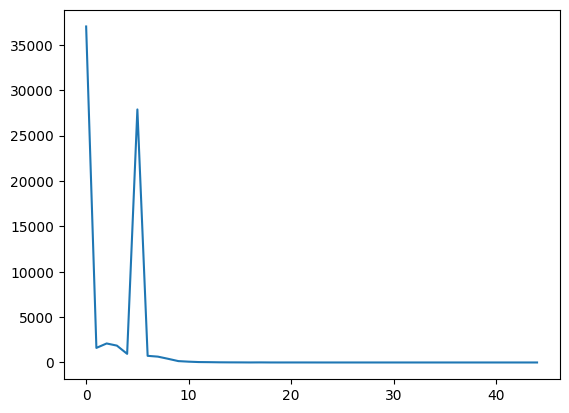

In [99]:
items_per_session.frq.plot()

In [97]:
duckdb.sql(
"""
WITH t AS (
    SELECT CASE 
        WHEN item_cnt = 0 THEN '1: 0'
        WHEN item_cnt < 5 THEN '2: 1 to 4'
        WHEN item_cnt < 10 THEN '3: 5 to 9'
        ELSE '4: 10+' END AS item_cnt_bin,
    frq
    FROM items_per_session
)
SELECT item_cnt_bin, SUM(frq) AS frq

FROM t
GROUP BY item_cnt_bin
ORDER BY item_cnt_bin
"""
).df().assign(cum_rel_frq = lambda df: df.frq.cumsum() / df.frq.sum())

,item_cnt_bin,frq,cum_rel_frq
0,1: 0,37028.0,0.502907
1,2: 1 to 4,6515.0,0.591392
2,3: 5 to 9,29820.0,0.996401
3,4: 10+,265.0,1.000000


In [105]:
(
    items_per_session
    .loc[lambda df: df.item_cnt > 0]
    .assign(
        rel_frq = lambda df: df.frq / df.frq.sum(),
        cum_rel_frq = lambda df: df.frq.cumsum() / df.frq.sum(),
    )
    [:10]
)

,item_cnt,frq,rel_frq,cum_rel_frq
1,1,1607,0.043907,0.043907
2,2,2096,0.057268,0.101175
3,3,1859,0.050792,0.151967
4,4,953,0.026038,0.178005
5,5,27885,0.761885,0.939891
6,6,733,0.020027,0.959918
7,7,645,0.017623,0.977541
8,8,405,0.011066,0.988607
9,9,152,0.004153,0.992760
10,10,90,0.002459,0.995219


Half of sessions have no transactions  
In the other half, 76% of sessions have exactly 5 items. Most curious